In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import *

%load_ext autoreload
%autoreload 2

#### Declare Variables 

In [48]:
n_states = 4 #number of states in the GMM
n_in = 1 #Number of variables for the radial basis function [s] (decay term)
n_out = 4 # Number of motion variables [xi,x2]

n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations

#### Load Data 

(1000, 4)


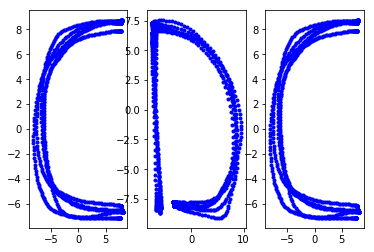

In [49]:
ROOT = 'python_data/2Dletters/'
data1 = np.load(ROOT + 'C.npy')[:n_samples]
data2 = np.load(ROOT + 'D.npy')[:n_samples]

#construct the output Y by concatenating all demonstrations in both dataset
data1 = data1.transpose([0,2,1])
data2 = data2.transpose([0,2,1])
data1 = np.concatenate(data1,axis=0)
data2 = np.concatenate(data2,axis=0)
Y = np.concatenate([data1,data2],axis=1)
print Y.shape

plt.subplot(1,3,1)
plt.plot(data1[:,0], data1[:,1],'.b')

plt.subplot(1,3,2)
plt.plot(data2[:,0], data2[:,1],'.b')

plt.subplot(1,3,3)
plt.plot(Y[:,0], Y[:,1],'.b')

#### Estimate GMM from the concatenated data [s_in, x_targets]

In [50]:
import time

In [229]:
gmm = MPPCA(K = n_states,D = n_out,n_fac = 2)
tic = time.time()
gmm.fit(Y,max_iter = 100, n_init = 1, init_type = 'kmeans')
toc = time.time()
print toc-tic

[[-4.207  4.244 -6.162  6.322]
 [-3.027 -5.221  6.55  -0.408]
 [ 6.364  8.407 -6.43  -4.593]
 [ 6.773 -6.583 -0.655 -7.965]]
[[[  9.82    8.775  -2.745  -1.915]
  [  8.775  12.073  -4.803  -1.455]
  [ -2.745  -4.803   4.555   0.143]
  [ -1.915  -1.455   0.143   1.339]]

 [[  7.273  -3.256   3.725 -10.009]
  [ -3.256   2.52   -2.03    4.28 ]
  [  3.725  -2.03    5.214  -6.391]
  [-10.009   4.28   -6.391  18.569]]

 [[  3.394   0.152   0.52   -5.405]
  [  0.152   0.1     0.094  -0.325]
  [  0.52    0.094   0.212  -1.387]
  [ -5.405  -0.325  -1.387  13.845]]

 [[  3.155  -0.044  -4.691   0.107]
  [ -0.044   0.129  -0.152  -0.047]
  [ -4.691  -0.152   9.998   0.042]
  [  0.107  -0.047   0.042   0.192]]]
[0. 0. 0. 0.]
6.946640790400258
[14.839 -3.149 -5.596 -6.094]
8.393924925119736
[19.808 -7.71  -6.43  -5.668]
4.387578544222035
[11.895 -3.283 -4.368 -4.244]
3.368264143221636
[ 9.016 -2.557 -3.189 -3.27 ]
[6.947 8.394 4.388 3.368]
Iteration 0
-7.603589940716476
Iteration 1
-8.6890989221718

[-10, 10, -10, 10]

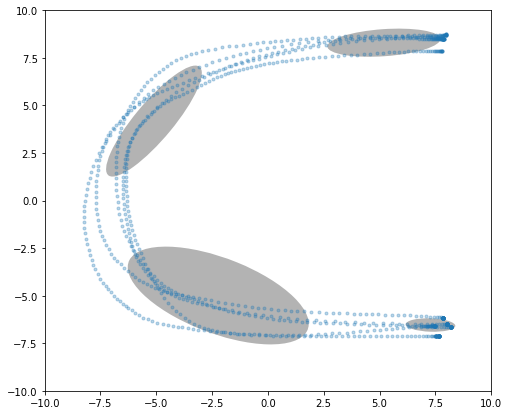

In [230]:
%matplotlib inline
fig = plt.figure(figsize=(8,7))
ax = fig.subplots()
plt.plot(Y[:,0], Y[:,1], '.', alpha=0.3)
plot_GMM(gmm.means_[:,:2], gmm.covariances_[:,:2,:2],ax)
plt.axis([-10,10,-10,10])

[-10, 10, -10, 10]

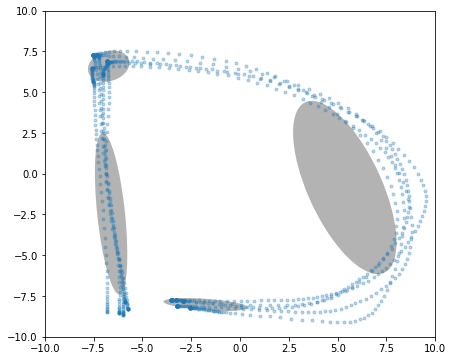

In [231]:
%matplotlib inline 
fig = plt.figure(figsize=(7,6))
ax = fig.subplots()
plt.plot(Y[:,2], Y[:,3], '.', alpha=0.3)
plot_GMM(gmm.means_[:,2:], gmm.covariances_[:,2:,2:],ax)
plt.axis([-10,10,-10,10])

In [226]:
from numpy import dot
from numpy.linalg import inv
class MPPCA(GMM):
    def __init__(self, D = 1, K = 2, n_fac = 1, reg_factor = 1e-6):
        self.D = D #number of dimensions
        self.K = K #number of mixture components
        self.L = -np.inf #total log likelihood
        self.weights_ = np.ones(K)/K
        self.means_ = np.random.rand(K,D)
        self.covariances_ = np.array([np.eye(D) for i in range(K)])
        
        self.Lambda_ = np.array([np.zeros((D,n_fac)) for i in range(K)])
        self.Psi_ = np.array([np.eye(D) for i in range(K)])
        self.sigma_ = np.ones(self.K)*1e-4
        
        self.n_fac = n_fac
        self.reg_factor = reg_factor
        

            
    def init_MPPCA(self):
        for k in range(self.K):
            self.sigma_[k] = np.trace(self.covariances_[k])/self.D
            print self.sigma_[k]
            D,V = np.linalg.eig(self.covariances_[k] - np.eye(self.D)*self.sigma_[k])
            indexes = np.argsort(D)[::-1]
            print D
            V = dot(V[:,indexes], np.diag(np.lib.scimath.sqrt(D[indexes])))
            self.Lambda_[k] = V[:,:self.n_fac]
                       

    def fit(self,x, max_iter = 10, init_type = 'kmeans', threshold = 1e-4, n_init = 5):
        self.x = x
        self.N = len(self.x) #number of datapoints
        self.Ls = np.zeros((self.N,self.K)) #posterior probability of z
        self.zs = np.zeros((self.N,self.K)) #posterior probability of z

        self.threshold = threshold
        
        best_params = ()
        Lmax = -np.inf

        for it in range(n_init):
            if init_type == 'kmeans':
                self.init_kmeans()
                print self.means_
                print self.covariances_
                print self.sigma_
            elif init_type == 'random':
                self.init_random()

            self.init_MPPCA()
            print self.sigma_
                
            for i in range(max_iter):
                print 'Iteration ' + str(i)
                
                #tic = time.time()
                self.expectation()
                #toc = time.time()
                #print 'Expectation computation', toc-tic
            
                #tic = time.time()
                self.maximization_1()
                #toc = time.time()
                #print 'Maximization 1 computation', toc-tic

                #self.expectation()
                
                #tic = time.time()
                self.maximization_2()
                #toc = time.time()
                #print 'Maximization 2 computation', toc-tic

                print self.L
                if np.abs(self.prev_L-self.L) < self.threshold:
                    break
                    
            if self.L > Lmax:
                Lmax = self.L
                best_params = (self.L, self.weights_.copy(), self.means_.copy(), self.covariances_.copy(), self.zs.copy(), self.Ns.copy())
            
        #return the best result
        self.L = Lmax
        self.weights_ = best_params[1]
        self.means_ = best_params[2]
        self.covariances_ = best_params[3]
        self.zs = best_params[4]
        self.Ns = best_params[5]
        print 'Obtain best result with Log Likelihood: ' + str(self.L)

    def maximization_1(self):
        for k in range(self.K):
            #update weight
            self.weights_[k] = self.Ns[k]/self.N 
            #update mean
            self.means_[k,:] = np.dot(self.zs[:,k].T, self.x)/self.Ns[k]  

    def maximization_2(self):
        #update covariance
        self.S = []
        self.M = []

        for k in range(self.K):
            x_reduce_mean = self.x-self.means_[k,:]
            #S_k = dot(x_reduce_mean.T, dot(np.diag(self.zs[:,k]), x_reduce_mean))
            S_k = dot(np.multiply(x_reduce_mean.T, self.zs[:,k][None,:]), x_reduce_mean)/self.Ns[k] + np.eye(self.D)*self.reg_factor
            M_k = dot(self.Lambda_[k].T,self.Lambda_[k]) + np.eye(self.n_fac)*self.sigma_[k]
            
            Lambda_k = dot(S_k,dot(self.Lambda_[k], inv(np.eye(self.n_fac)*self.sigma_[k] + \
                                dot(inv(M_k),dot(self.Lambda_[k].T,dot(S_k, self.Lambda_[k]) )  ))))
            self.S.append(S_k)
            self.M.append(M_k)
            
            
            self.sigma_[k] = np.trace(S_k-dot(S_k,dot(self.Lambda_[k],dot(inv(M_k),Lambda_k.T))))/self.D
            self.Psi_[k] = np.eye(self.D)*self.sigma_[k]
            
            self.Lambda_[k] = Lambda_k.copy()
            
            self.covariances_[k] = dot(self.Lambda_[k], self.Lambda_[k].T) + self.Psi_[k]
           